In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, '/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraRGB/')
mask_path = os.path.join(path, '/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraSeg/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

<ipython-input-4-548bd8b85d22>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-4-548bd8b85d22>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

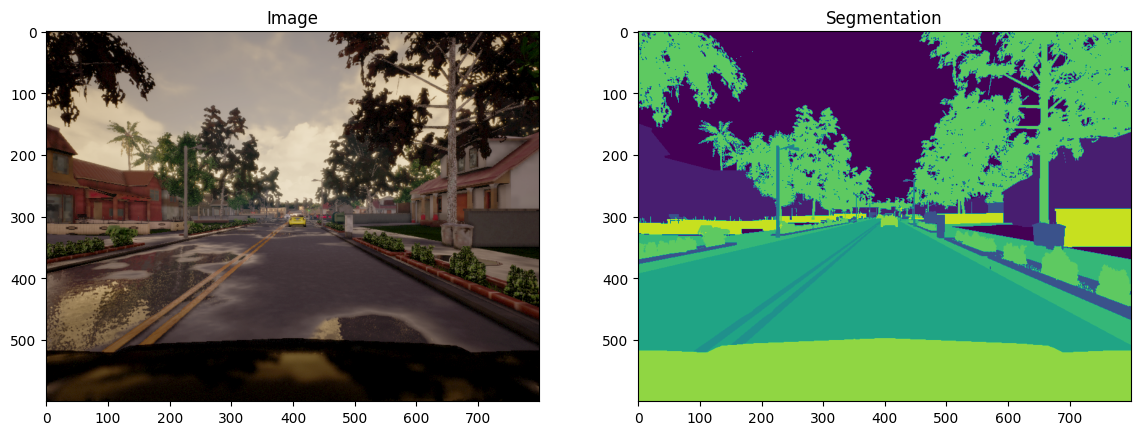

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraRGB/F61-1.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraSeg/F61-1.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraRGB/F61-10.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraSeg/F61-10.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraRGB/F61-100.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraSeg/F61-100.png'>)


In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraRGB/F61-1.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/TCC/carla-capture-20180513A/CameraSeg/F61-1.png', shape=(), dtype=string)


In [7]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [8]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96 + 32, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96 + 32, 128), method='nearest')

    input_image = input_image / 255.

    # Recorta a parte inferior da imagem e da máscara
    cropped_image = input_image[:-32, :, :]
    cropped_mask = input_mask[:-32, :, :]

    return cropped_image, cropped_mask

# Cria um conjunto de dados com as imagens originais
original_dataset = dataset.map(process_path)
processed_original_ds = original_dataset.map(preprocess)

# Cria um novo conjunto de dados com as imagens espelhadas
mirrored_dataset = dataset.map(process_path)
mirrored_dataset = mirrored_dataset.map(preprocess)
mirrored_dataset = mirrored_dataset.map(lambda image, mask: (tf.image.flip_left_right(image), tf.image.flip_left_right(mask)))

# Junta os dois conjuntos de dados
combined_dataset = processed_original_ds.concatenate(mirrored_dataset)

# Divide o conjunto de dados combinado em treinamento e teste
train_dataset = combined_dataset.take(3200)  # 80% dos dados para treinamento
test_dataset = combined_dataset.skip(800)  # 20% dos dados para teste


(96, 128, 3)


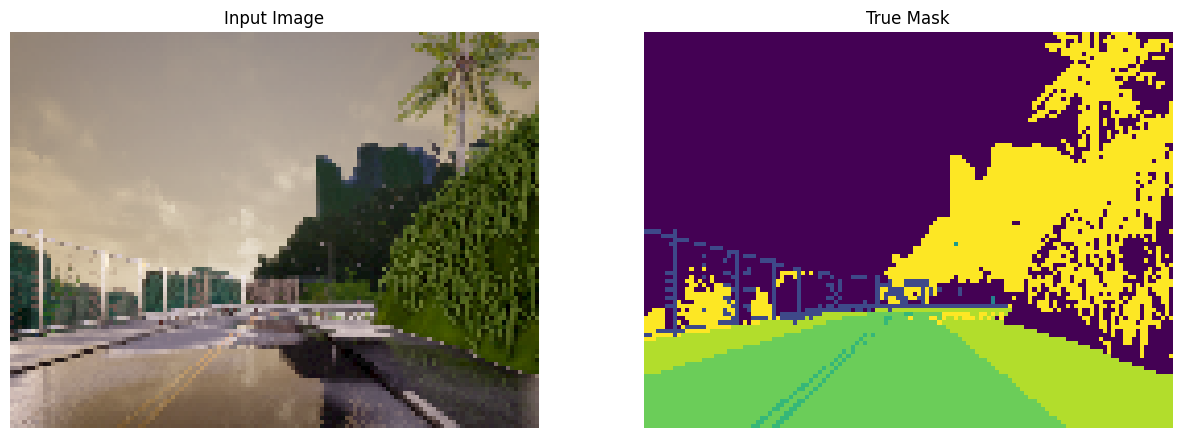

(96, 128, 3)


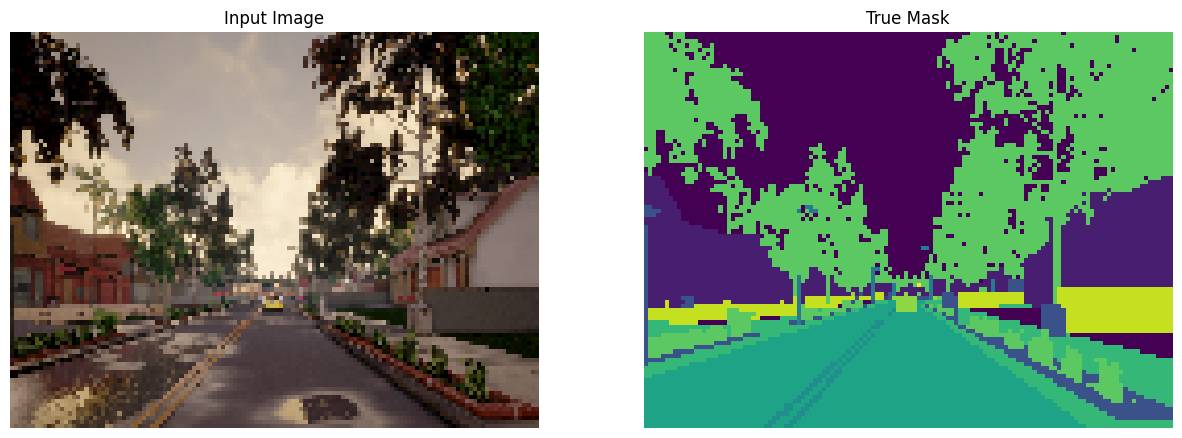

In [9]:
for image, mask in test_dataset.take(1):
    sample_image, sample_mask = image, mask
    print(sample_image.shape)
display([sample_image, sample_mask])

for image, mask in train_dataset.take(1):
    sample_image, sample_mask = image, mask
    print(sample_image.shape)
display([sample_image, sample_mask])

In [23]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D()(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [24]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv

In [25]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_80 (Conv2D)          (None, 96, 128, 32)          896       ['input_5[0][0]']             
                                                                                                  
 conv2d_81 (Conv2D)          (None, 96, 128, 32)          9248      ['conv2d_80[0][0]']           
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 48, 64, 32)           0         ['conv2d_81[0][0]']           
 ng2D)                                                                                      

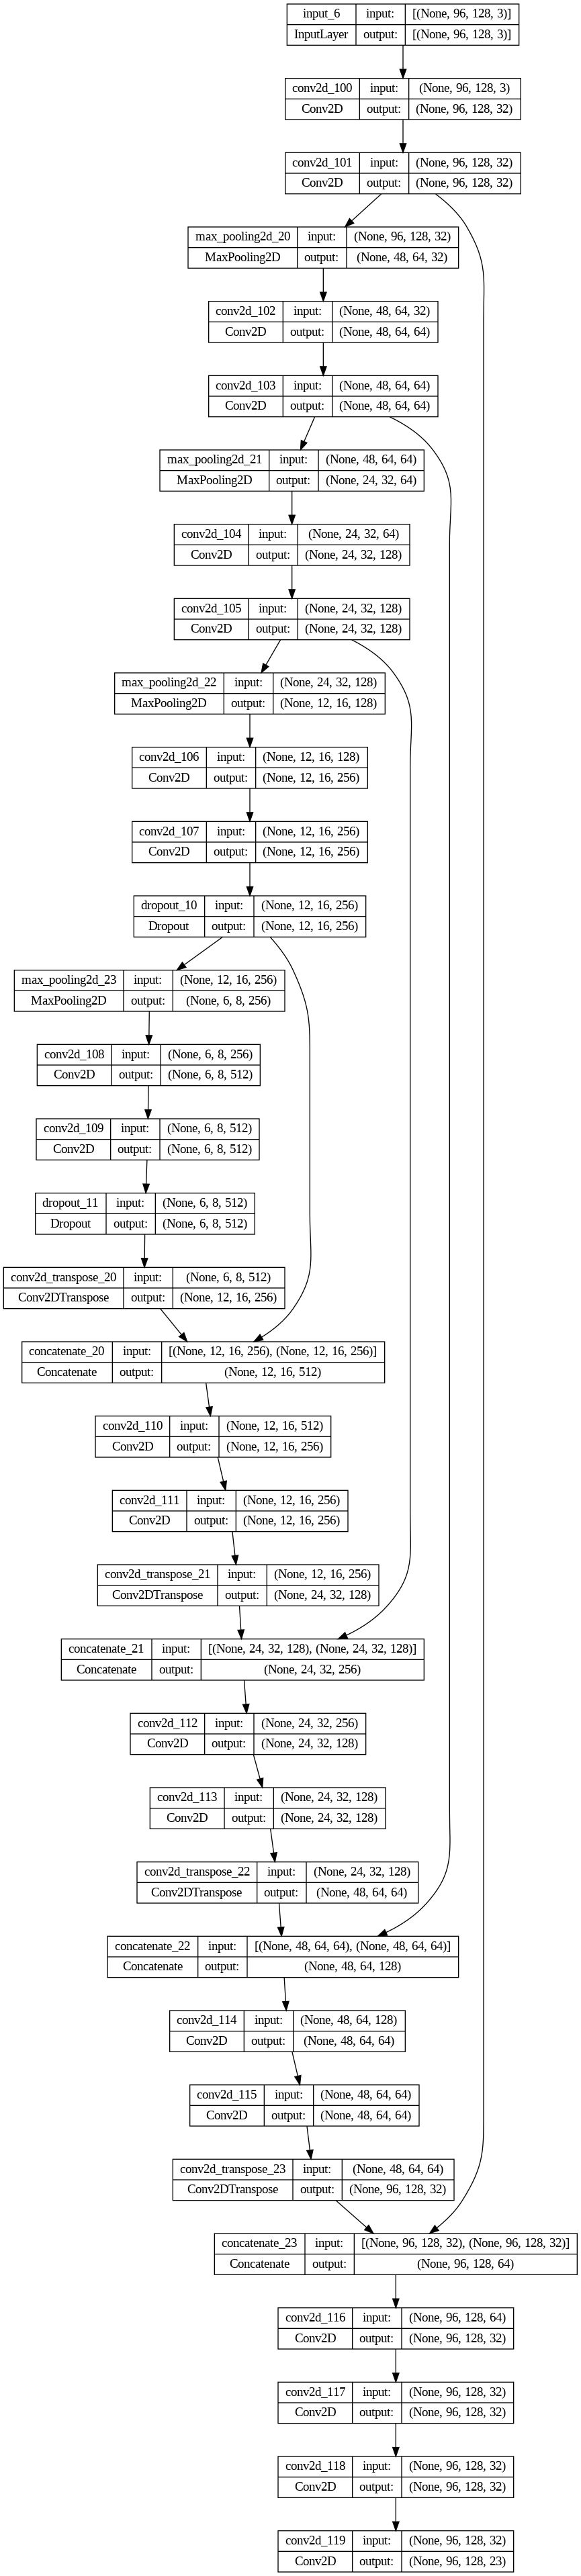

In [29]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

from tensorflow.keras.utils import plot_model

plot_model(unet, to_file='model.png', show_shapes=True, show_layer_names=True)

In [30]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
EPOCHS = 45
BUFFER_SIZE = 3200
BATCH_SIZE = 32
train_dataset.batch(BATCH_SIZE)
train_dataset_cache = combined_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset.element_spec)
model_history = unet.fit(train_dataset_cache, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/45
63/63 [==============================] - 54s 154ms/step - loss: 2.6391 - accuracy: 0.3196
Epoch 2/45
63/63 [==============================] - 10s 154ms/step - loss: 1.3832 - accuracy: 0.4573
Epoch 3/45
63/63 [==============================] - 10s 155ms/step - loss: 0.9766 - accuracy: 0.6275
Epoch 4/45
63/63 [==============================] - 10s 154ms/step - loss: 0.7940 - accuracy: 0.7011
Epoch 5/45
63/63 [==============================] - 10s 157ms/step - loss: 0.6952 - accuracy: 0.7556
Epoch 6/45
63/63 [==============================] - 10s 157ms/step - loss: 0.6177 - accuracy: 0.7954
Epoch 7/45
63/63 [==============================] - 10s 158ms/step - loss: 0.5219 - accuracy: 0.8323
Epoch 8/45
63/63 [==============================] - 10s 159ms/step - loss: 0.4946 - accuracy: 0.8390
Epoch 9/45
63/63 [==============================] - 10s 159ms/step - lo

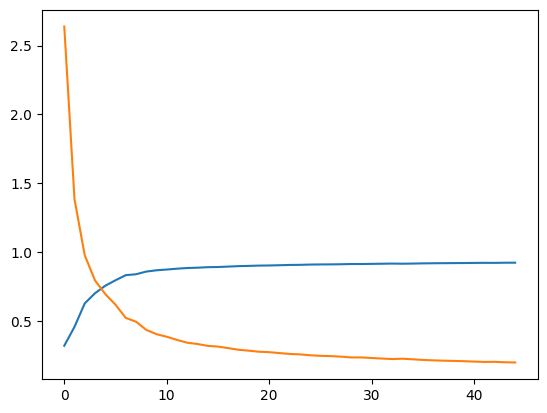

In [32]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["loss"])

1/1 [==============================] - 0s 356ms/step


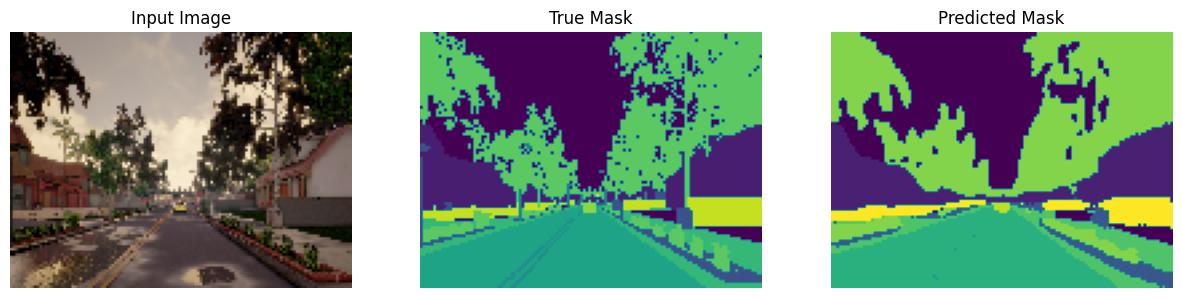

In [33]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
  display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

show_predictions(train_dataset, 6000)

In [34]:
path = 'model_unet'

tf.saved_model.save(unet, path)

In [35]:
unetSaved = tf.saved_model.load(path)

In [36]:
print(unetSaved.signatures.get('serving_default'))

tf.saved_model.save(unetSaved, path, signatures=unetSaved.signatures.get('serving_default'))

ConcreteFunction signature_wrapper(*, input_6)
  Args:
    input_6: float32 Tensor, shape=(None, 96, 128, 3)
  Returns:
    {'conv2d_119': <1>}
      <1>: float32 Tensor, shape=(None, 96, 128, 23)


In [37]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(path) # path to the SavedModel directory
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('model_semantic.tflite', 'wb') as f:
  f.write(tflite_model)

In [38]:
TFLITE_MODEL = "model_semantic.tflite"

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()
print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: serving_default_input_6:0
shape: [  1  96 128   3]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'serving_default_input_6:0', 'index': 0, 'shape': array([  1,  96, 128,   3], dtype=int32), 'shape_signature': array([ -1,  96, 128,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

== Output details ==
name: StatefulPartitionedCall:0
shape: [  1  96 128  23]
type: <class 'numpy.float32'>

DUMP OUTPUT
{'name': 'StatefulPartitionedCall:0', 'index': 107, 'shape': array([  1,  96, 128,  23], dtype=int32), 'shape_signature': array([ -1,  96, 128,  23], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}